In [1]:
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [4]:
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('2016_Building.csv',  engine = 'python',  on_bad_lines = 'skip')

In [6]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [7]:
data.shape

(3376, 46)

# 1. Nettoyage des données

## 1.1  éliminer les propriétes avec les conditions :
- Building résidentiel (Multifamily)
- Building with default data (The property used default data for at least one property characteristic.)
- Outliers buildings  (Whether a property is a high or low outlier (Y/N))
- Compliances (Whether a property has met energy benchmarking requirements for the current reporting year.)

In [8]:
data.BuildingType.str.contains('Multifamily').sum()/len(data)

0.5059241706161137

In [9]:
data['DefaultData'].apply(lambda x: x).sum()/len(data)

0.03347156398104265

In [10]:
data['Outlier'].notnull().sum()/len(data)

0.009478672985781991

In [11]:
data['ComplianceStatus'].apply(lambda x: (x != 'Compliant')).sum()/len(data)

0.04887440758293839

In [12]:
data_1 = data.drop(data[data['BuildingType'].str.contains('Multifamily')].index)

In [13]:
data_1.shape

(1668, 46)

In [14]:
data_1 = data_1.drop(data_1[data_1['DefaultData']].index)

In [15]:
data_1.shape

(1580, 46)

In [16]:
data_1 = data_1.drop(data_1[~data_1['ComplianceStatus'].str.contains('Compliant')].index)

In [17]:
data_1.shape

(1566, 46)

In [18]:
data_1 = data_1.drop(data_1[data_1['Outlier'].notnull()].index)

In [19]:
data_1.shape

(1551, 46)

In [20]:
data_1.to_csv('data_1.csv')

## 1.2  éliminer les features  qui ne sont pas utilisées :

In [21]:
Nouse_features = ['DataYear', 'PropertyName', 'BuildingType', 'City', 'State', 'ZipCode', 'Outlier', 'ComplianceStatus','DefaultData', 'YearsENERGYSTARCertified', 'TaxParcelIdentificationNumber', 'Address', 'Comments', 'Neighborhood',\
                 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'NumberofBuildings', \
                 'OSEBuildingID', 'ListOfAllPropertyUseTypes']

In [22]:
data_2 = data_1.drop(columns = Nouse_features)

In [23]:
# Supprimer les colonnes non numériques ou non pertinentes
data_2 = data_2.drop(['Latitude', 'Longitude', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'NaturalGas(therms)',\
              'Electricity(kWh)','SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)','TotalGHGEmissions','SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'], axis=1)


In [24]:
data_2.shape

(1551, 11)

In [25]:
data_2.head()

,PrimaryPropertyType,CouncilDistrictCode,YearBuilt,NumberofFloors,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
0,Hotel,7,1927,12,60.0,81.699997,182.500000,2003882.00,3946027.0,1276453.0,2.83
1,Hotel,7,1996,11,61.0,94.800003,176.100006,0.00,3242851.0,5145082.0,2.86
2,Hotel,7,1969,41,43.0,96.000000,241.899994,21566554.00,49526664.0,1493800.0,2.19
3,Hotel,7,1926,10,56.0,110.800003,216.199997,2214446.25,2768924.0,1811213.0,4.67
4,Hotel,7,1980,18,75.0,114.800003,211.399994,0.00,5368607.0,8803998.0,2.88


## 1.3  traiement valeurs manquantes, invalides, doublons, outliers 

In [26]:
data_3 = data_2.copy()

In [27]:
data_3.duplicated().sum()

0

### 1.3.1 valeurs manquantes

In [28]:
print(data_3.isnull().sum())

PrimaryPropertyType        0
CouncilDistrictCode        0
YearBuilt                  0
NumberofFloors             0
ENERGYSTARScore          554
SiteEUI(kBtu/sf)           3
SourceEUI(kBtu/sf)         2
SteamUse(kBtu)             2
Electricity(kBtu)          2
NaturalGas(kBtu)           2
GHGEmissionsIntensity      2
dtype: int64


In [29]:
# Calculer la moyenne de ENERGYSTARScore par groupe de PrimaryPropertyType
moyenne_par_proprietyType = data_3.groupby('PrimaryPropertyType')['ENERGYSTARScore'].mean()

# Calculer la moyenne de toutes les valeurs non manquantes de ENERGYSTARScore
overall_mean = data_3['ENERGYSTARScore'].mean()

# Remplacer les valeurs manquantes de ENERGYSTARScore par la moyenne de groupe de PrimaryPropertyType
data_3['ENERGYSTARScore'] = data_3.apply(lambda row: moyenne_par_proprietyType[row['PrimaryPropertyType']] \
    if np.isnan(row['ENERGYSTARScore']) else row['ENERGYSTARScore'],  axis=1)

In [31]:
print(data_3.isnull().sum())

PrimaryPropertyType       0
CouncilDistrictCode       0
YearBuilt                 0
NumberofFloors            0
ENERGYSTARScore          74
SiteEUI(kBtu/sf)          3
SourceEUI(kBtu/sf)        2
SteamUse(kBtu)            2
Electricity(kBtu)         2
NaturalGas(kBtu)          2
GHGEmissionsIntensity     2
dtype: int64


In [32]:
# Remplacer le reste des valeurs manquantes de ENERGYSTARScore par la moyenne global de ENERGYSTARScore
data_3['ENERGYSTARScore'] = data_3.apply(lambda row: overall_mean\
    if np.isnan(row['ENERGYSTARScore']) else row['ENERGYSTARScore'],  axis=1)

In [33]:
data_3[data_3.isnull().any(axis=1)]

,PrimaryPropertyType,CouncilDistrictCode,YearBuilt,NumberofFloors,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
304,Other,7,1990,6,62.363636,NaN,0.0,0.0,0.0,0.0,0.0
578,Small- and Mid-Sized Office,7,1924,4,67.217949,NaN,NaN,NaN,NaN,NaN,NaN
2670,Mixed Use Property,4,1928,2,61.961538,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data_3 = data_3.dropna(axis=0, how='any')

In [35]:
print(data_3.isnull().sum())

PrimaryPropertyType      0
CouncilDistrictCode      0
YearBuilt                0
NumberofFloors           0
ENERGYSTARScore          0
SiteEUI(kBtu/sf)         0
SourceEUI(kBtu/sf)       0
SteamUse(kBtu)           0
Electricity(kBtu)        0
NaturalGas(kBtu)         0
GHGEmissionsIntensity    0
dtype: int64


In [36]:
data_3.shape

(1548, 11)

### 1.3.2 invalides :  
remove row with negative values

In [38]:
keep_columns = ['PrimaryPropertyType']

# Create a mask to identify rows with negative values
mask = (data_3.drop(keep_columns, axis=1) < 0).any(axis=1)

# Drop the rows with negative values
data_3 = data_3[~mask]

In [39]:
data_3.shape

(1547, 11)

In [40]:
# if numberofflower is 0, put it into 1. 

data_3['NumberofFloors'] = data_3['NumberofFloors'].replace(0,1)

In [41]:
# d'autres zero value to check 

In [43]:
count_zeros = data_3.eq(0).sum()
print(count_zeros)

PrimaryPropertyType         0
CouncilDistrictCode         0
YearBuilt                   0
NumberofFloors              0
ENERGYSTARScore             0
SiteEUI(kBtu/sf)            0
SourceEUI(kBtu/sf)          2
SteamUse(kBtu)           1434
Electricity(kBtu)           2
NaturalGas(kBtu)          443
GHGEmissionsIntensity       1
dtype: int64


In [46]:
data_3 = data_3.drop(data_3[data_3['SourceEUI(kBtu/sf)']==0].index)
data_3 = data_3.drop(data_3[data_3['Electricity(kBtu)']==0].index)
data_3 = data_3.drop(data_3[data_3['GHGEmissionsIntensity']==0].index)

In [47]:
count_zeros = data_3.eq(0).sum()
print(count_zeros)

PrimaryPropertyType         0
CouncilDistrictCode         0
YearBuilt                   0
NumberofFloors              0
ENERGYSTARScore             0
SiteEUI(kBtu/sf)            0
SourceEUI(kBtu/sf)          0
SteamUse(kBtu)           1431
Electricity(kBtu)           0
NaturalGas(kBtu)          441
GHGEmissionsIntensity       0
dtype: int64


In [48]:
data_3.to_csv('data_3.csv')

### 1.3.3  traitement outliers

In [49]:
Q1 = data_3.quantile(0.25)
Q3 = data_3.quantile(0.75)
IQR = Q3 - Q1
outliers = (data_3 < (Q1 - 1.5 * IQR)) | (data_3 > (Q3 + 1.5 * IQR))
outliers_num = (outliers == True).sum().sort_values(ascending=False)
outliers_per = (((outliers == True).sum()/len(data_3))*100).sort_values(ascending=False)
(outliers == True).sum().sum()

1109

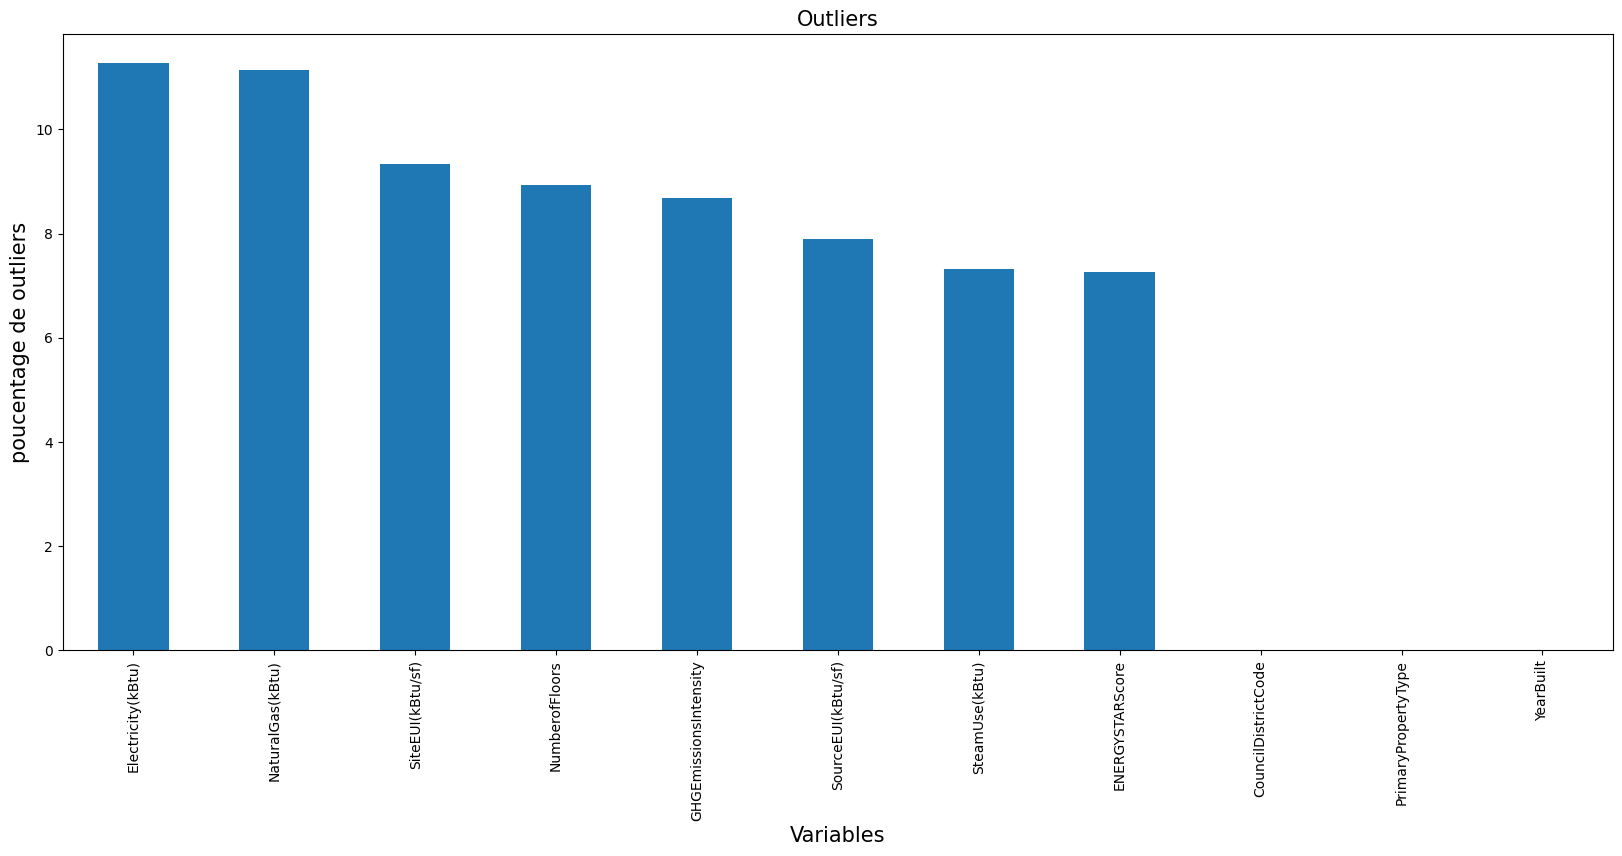

In [50]:
outliers_per.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Variables', fontsize=15)
plt.ylabel('poucentage de outliers', fontsize=15)
plt.title('Outliers', fontsize=15)
plt.show()

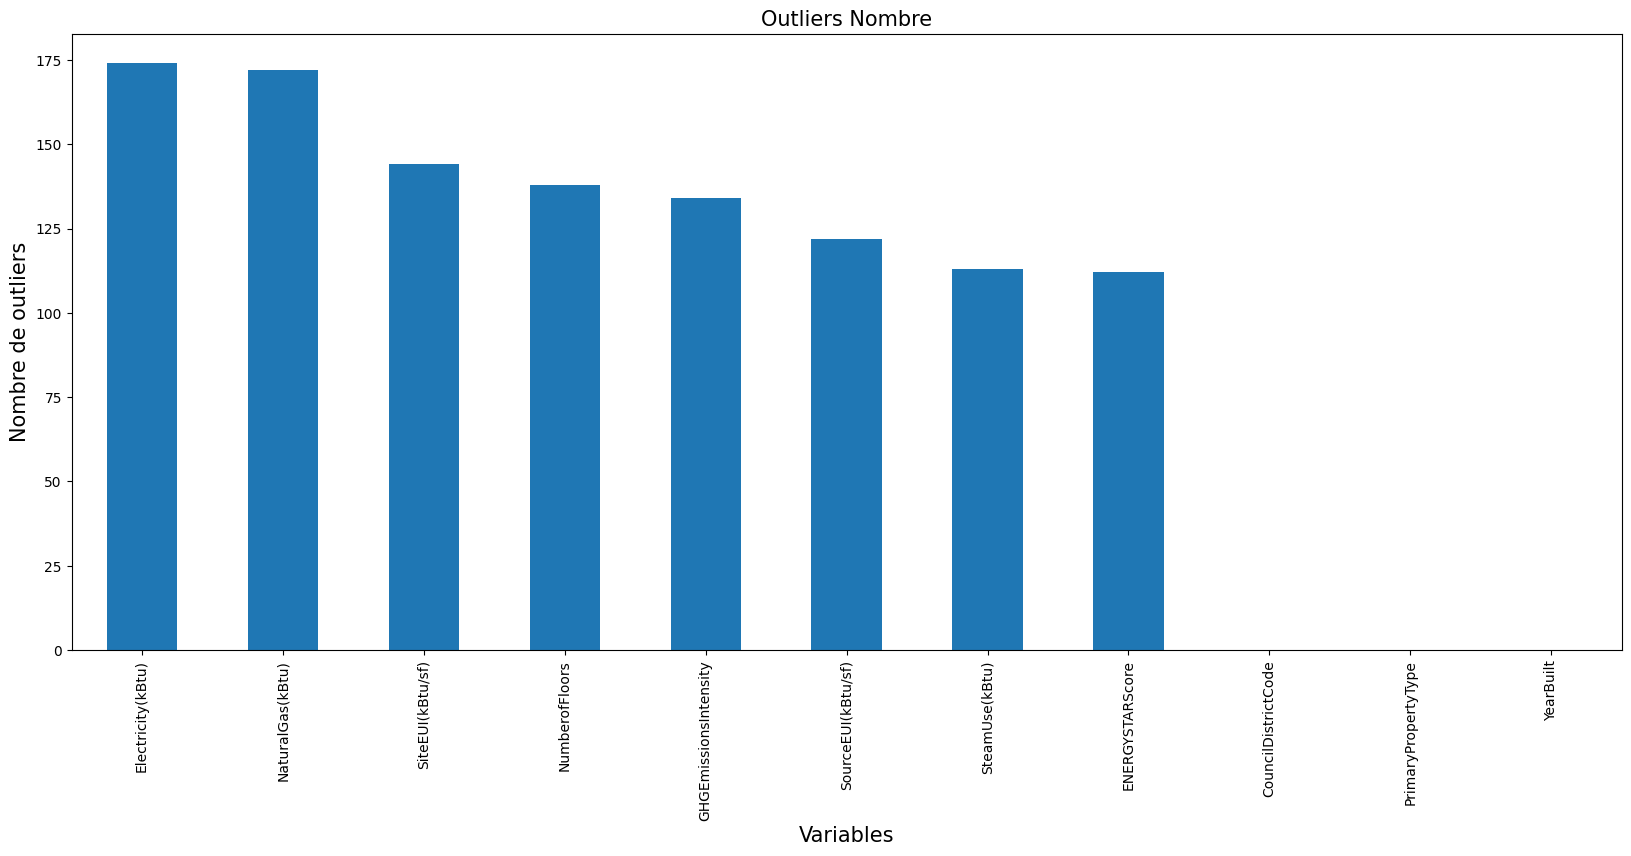

In [51]:
outliers_num.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Variables', fontsize=15)
plt.ylabel('Nombre de outliers', fontsize=15)
plt.title('Outliers Nombre', fontsize=15)
plt.show()

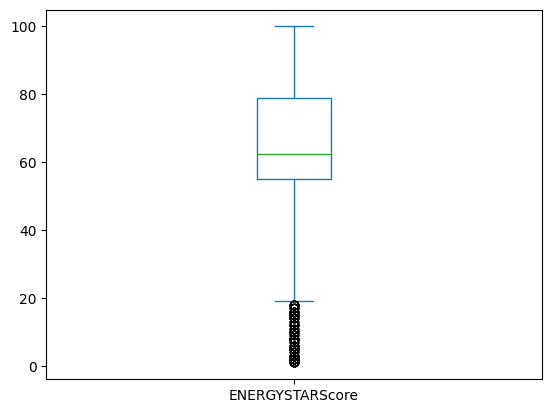

In [52]:
data_3['ENERGYSTARScore'].plot.box()
plt.show()

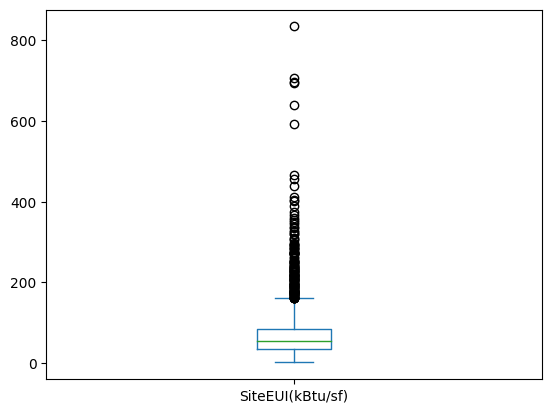

In [53]:
data_3['SiteEUI(kBtu/sf)'].plot.box()
plt.show()

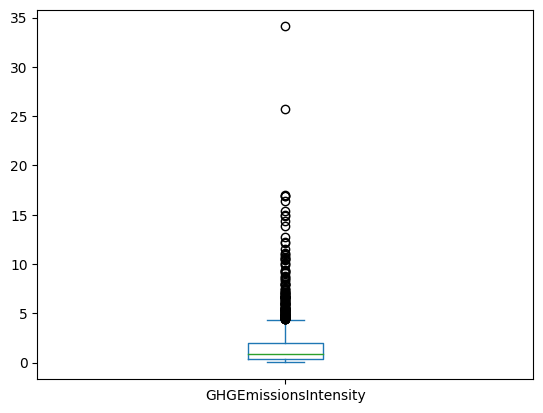

In [54]:
data_3['GHGEmissionsIntensity'].plot.box()
plt.show()

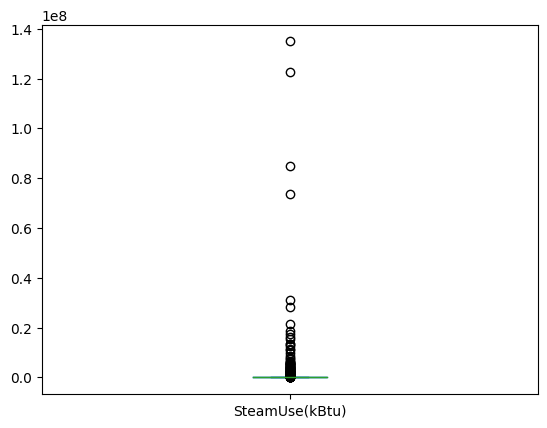

In [55]:
data_3['SteamUse(kBtu)'].plot.box()
plt.show()

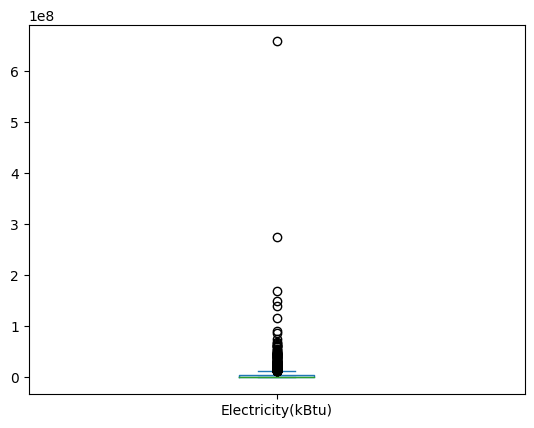

In [56]:
data_3['Electricity(kBtu)'].plot.box()
plt.show()

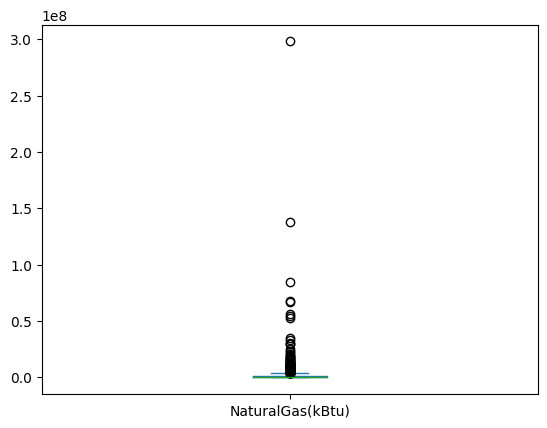

In [57]:
data_3['NaturalGas(kBtu)'].plot.box()
plt.show()

In [60]:
data_3.to_csv('data_3.csv')

## 1.4 Transform categorial variables en dummy variables 

In [58]:
#les variables catégiriels sont CouncilDistrictCode, YearBuilt?, PrimaryPropertyType

from sklearn.preprocessing import LabelEncoder

data_4 = data_3.copy()
# create a LabelEncoder object

data_4 = pd.get_dummies(data_4, columns=['PrimaryPropertyType'])


data_4.head()


,CouncilDistrictCode,YearBuilt,NumberofFloors,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,...,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility
0,7,1927,12,60.0,81.699997,182.500000,2003882.00,3946027.0,1276453.0,2.83,...,0,0,0,0,0,0,0,0,0,0
1,7,1996,11,61.0,94.800003,176.100006,0.00,3242851.0,5145082.0,2.86,...,0,0,0,0,0,0,0,0,0,0
2,7,1969,41,43.0,96.000000,241.899994,21566554.00,49526664.0,1493800.0,2.19,...,0,0,0,0,0,0,0,0,0,0
3,7,1926,10,56.0,110.800003,216.199997,2214446.25,2768924.0,1811213.0,4.67,...,0,0,0,0,0,0,0,0,0,0
4,7,1980,18,75.0,114.800003,211.399994,0.00,5368607.0,8803998.0,2.88,...,0,0,0,0,0,0,0,0,0,0


In [59]:
data_4.to_csv('data_4.csv')

In [81]:
data_4.dtypes

CouncilDistrictCode                                  int64
YearBuilt                                            int64
NumberofFloors                                       int64
ListOfAllPropertyUseTypes                           object
ENERGYSTARScore                                    float64
SiteEUI(kBtu/sf)                                   float64
SourceEUI(kBtu/sf)                                 float64
SteamUse(kBtu)                                     float64
Electricity(kBtu)                                  float64
NaturalGas(kBtu)                                   float64
GHGEmissionsIntensity                              float64
PrimaryPropertyType_Distribution Center              uint8
PrimaryPropertyType_Hospital                         uint8
PrimaryPropertyType_Hotel                            uint8
PrimaryPropertyType_K-12 School                      uint8
PrimaryPropertyType_Laboratory                       uint8
PrimaryPropertyType_Large Office                     uin

In [ ]:

# fit and transform the encoder on the categorical column
data_4['PrimaryPropertyType_encoded'] = label_encoder.fit_transform(data_4['PrimaryPropertyType'])
data_4['ListOfAllPropertyUseTypes_encoded'] = label_encoder.fit_transform(data_4['ListOfAllPropertyUseTypes'])

data_4 = data_4.drop(['PrimaryPropertyType', 'ListOfAllPropertyUseTypes'], axis = 1)

In [126]:
data_5 = data_4.copy()